In [1]:
import gc
import math
import random
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Dropout, TimeDistributed, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import  SGD, RMSprop, Adam
from functools import cmp_to_key
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/10_nodes_new')

edges = [[1, 2], [1, 5], [1, 8], [2, 3], [3, 4], [3, 8], [3, 9], [4, 10], [5, 6], [6, 7], [6, 8], [6, 9], [7, 10], [9, 10]]
number_edges = len(edges)
number_steps = 4
start_node = 1
end_node = 10

df = pd.read_csv('gdrive/My Drive/Colab Notebooks/10_nodes_new/data/10_nodes_LU.csv')
x = df.iloc[:,:number_edges].values
y = df.iloc[:,number_edges:].values

df_hp = pd.read_csv('gdrive/My Drive/Colab Notebooks/10_nodes_new/data/10_nodes_LU_hp.csv')
x_hp = df_hp.iloc[:,:number_edges].values
y_hp = df_hp.iloc[:,number_edges:].values

from sklearn.model_selection import train_test_split
x_main_train,x_main_tv,y_main_train,y_main_tv = train_test_split(x,y,test_size=2/5)
x_main_test,x_main_valid,y_main_test,y_main_valid = train_test_split(x_main_tv,y_main_tv,test_size=1/2)

x_hp_train,x_hp_tv,y_hp_train,y_hp_tv = train_test_split(x_hp,y_hp,test_size=2/5)
x_hp_test,x_hp_valid,y_hp_test,y_hp_valid = train_test_split(x_hp_tv,y_hp_tv,test_size=1/2)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_main_train)
x_test = sc.transform(x_main_test)
x_valid = sc.transform(x_main_valid)

sc_hp = StandardScaler()
x_train_1 = sc_hp.fit_transform(x_hp_train)
x_test_1 = sc_hp.transform(x_hp_test)
x_valid_1 = sc_hp.transform(x_hp_valid)

x_train = np.repeat(x_train[:, np.newaxis, : ], number_steps, axis=1)
x_test = np.repeat(x_test[:, np.newaxis, : ], number_steps, axis=1)
x_valid = np.repeat(x_valid[:, np.newaxis, : ], number_steps, axis=1)

x_train_1 = np.repeat(x_train_1[:, np.newaxis, : ], number_steps, axis=1)
x_test_1 = np.repeat(x_test_1[:, np.newaxis, : ], number_steps, axis=1)
x_valid_1 = np.repeat(x_valid_1[:, np.newaxis, : ], number_steps, axis=1)

y_train = np.reshape(y_main_train,(y_main_train.shape[0], number_steps, number_edges))
y_test = np.reshape(y_main_test,(y_main_test.shape[0], number_steps, number_edges))
y_valid = np.reshape(y_main_valid,(y_main_valid.shape[0], number_steps, number_edges))

y_train_1 = np.reshape(y_hp_train,(y_hp_train.shape[0], number_steps, number_edges))
y_test_1 = np.reshape(y_hp_test,(y_hp_test.shape[0], number_steps, number_edges))
y_valid_1 = np.reshape(y_hp_valid,(y_hp_valid.shape[0], number_steps, number_edges))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_valid.shape, y_valid.shape, x_train_1.shape, y_train_1.shape, x_test_1.shape, y_test_1.shape)

# Hyperparameters of structure: number of layers, number of units, dropout, cell type
# Hyperparameters of training: learning rate, batch size
HP_1 = [[1, 2, 3, 4, 5],
       [-1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, -1],
       [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
       [SimpleRNN, GRU, LSTM],
       [SGD, RMSprop, Adam],
       [0.0001, 0.001, 0.01, 0.1],
       [16, 32, 64, 128, 256, 512, 1024]]

t = []
for p in HP_1:
    t.append(len(p))
t1 = []
hp = []
for i in range(t[0]):
    t1.append(t[1])
    t1.append(t[2])
    hp.append(HP_1[1])
    hp.append(HP_1[2])
for i in range(3, len(HP_1)):
    t1.append(t[i])
    hp.append(HP_1[i])
t2 = [int(np.sqrt(itm)) for itm in t1]
n_hp = 2*t[0] + len(HP_1) - 3
print(t, t1, t2, n_hp)

from Results import Results
def custom_accuracy(y_true, y_pred):
    threshold = 0.5
    y_pred_binary = tf.cast(tf.greater_equal(y_pred, threshold), tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    stepwise_correct = tf.reduce_all(tf.equal(y_true, y_pred_binary), axis=-1)
    sequencewise_correct = tf.reduce_all(stepwise_correct, axis=-1)
    acc = tf.reduce_mean(tf.cast(sequencewise_correct, tf.float32))
    return acc

Mounted at /content/gdrive
(600000, 4, 14) (600000, 4, 14) (200000, 4, 14) (200000, 4, 14) (200000, 4, 14) (200000, 4, 14) (6000, 4, 14) (6000, 4, 14) (2000, 4, 14) (2000, 4, 14)
[5, 22, 6, 3, 3, 4, 7] [22, 6, 22, 6, 22, 6, 22, 6, 22, 6, 3, 3, 4, 7] [4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 1, 1, 2, 2] 14


In [ ]:
best_hps = []
with open('gdrive/My Drive/Colab Notebooks/10_nodes_new/ACO/acc/AS.txt') as f:
    lines = f.readlines()
    for line in lines:
        a = line.split(",")
        b = [int(i) for i in a]
        best_hps.append(b)
best_hps

[[14, 2, 12, 0, 4, 2, 12, 2, 12, 0, 1, 1, 2, 4],
 [11, 0, 16, 1, 5, 4, 8, 0, 6, 0, 1, 2, 1, 2],
 [0, 0, 18, 0, 18, 0, 18, 5, 18, 5, 2, 2, 1, 2],
 [10, 3, 18, 1, 10, 3, 10, 1, 14, 4, 1, 2, 1, 1],
 [0, 1, 12, 2, 10, 2, 10, 4, 0, 2, 2, 1, 2, 3],
 [16, 3, 20, 1, 16, 0, 4, 1, 11, 1, 1, 1, 1, 2],
 [13, 0, 14, 0, 14, 0, 13, 3, 18, 0, 1, 1, 2, 4],
 [9, 0, 20, 4, 17, 0, 15, 4, 15, 2, 1, 2, 1, 1],
 [15, 5, 7, 2, 11, 2, 15, 4, 15, 2, 2, 2, 1, 3],
 [0, 3, 17, 1, 17, 2, 20, 2, 21, 5, 2, 2, 1, 2],
 [11, 1, 21, 4, 11, 4, 11, 2, 20, 3, 1, 1, 2, 3],
 [6, 2, 19, 0, 21, 1, 5, 2, 17, 2, 1, 1, 1, 0],
 [20, 3, 15, 3, 0, 0, 21, 3, 12, 3, 1, 2, 1, 3],
 [0, 0, 16, 3, 20, 4, 13, 3, 16, 4, 2, 1, 2, 3],
 [17, 1, 5, 2, 8, 3, 7, 1, 14, 4, 1, 2, 2, 5],
 [13, 4, 13, 3, 21, 3, 5, 0, 15, 4, 1, 1, 1, 1],
 [10, 1, 13, 1, 10, 4, 10, 1, 2, 1, 1, 2, 1, 2],
 [18, 3, 17, 2, 14, 3, 11, 1, 12, 4, 1, 2, 1, 2],
 [15, 4, 0, 4, 0, 1, 15, 4, 3, 1, 2, 1, 2, 2],
 [0, 3, 12, 4, 21, 4, 4, 0, 5, 3, 2, 1, 2, 3]]

In [ ]:
best_hps[2]

[0, 0, 18, 0, 18, 0, 18, 5, 18, 5, 2, 2, 1, 2]

In [ ]:
data_x_train = x_train
data_y_train = y_train

data_x_valid = x_valid
data_y_valid = y_valid

data_x_test = x_test
data_y_test = y_test

data_x_original_train = x_main_train
data_x_original_test = x_main_test

In [ ]:
# data_x_train = x_train_1
# data_y_train = y_train_1

# data_x_valid = x_valid_1
# data_y_valid = y_valid_1

# data_x_test = x_test_1
# data_y_test = y_test_1

# data_x_original_train = x_hp_train
# data_x_original_test = x_hp_test

In [ ]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(MyCustomCallback, self).__init__()
        self.r = Results(number_edges, edges, start_node, end_node, number_steps)
        self.actual_loss = []
        self.actual_accuracy = []
        self.training_path_1 = []
        self.training_path_2 = []
        self.training_path_3 = []
        self.training_path_4 = []
        self.training_all_paths = []
        self.testing_path_1 = []
        self.testing_path_2 = []
        self.testing_path_3 = []
        self.testing_path_4 = []
        self.testing_all_paths = []

    def on_epoch_end(self, epoch, logs=None):
        res_eval_1 = self.model.evaluate(data_x_train, data_y_train, verbose = 0)
        self.actual_loss.append(res_eval_1[0])
        self.actual_accuracy.append(res_eval_1[1])
        pred = model.predict(data_x_train, verbose = 0)
        pred_test = model.predict(data_x_test, verbose = 0)
        accuracy_train = list(self.r.get_accuracy(pred, data_x_original_train, data_y_train))
        accuracy_test = list(self.r.get_accuracy(pred_test, data_x_original_test, data_y_test))
        self.training_path_1.append(accuracy_train[0])
        self.training_path_2.append(accuracy_train[1])
        self.training_path_3.append(accuracy_train[2])
        self.training_path_4.append(accuracy_train[3])
        self.training_all_paths.append(accuracy_train[4])
        self.testing_path_1.append(accuracy_test[0])
        self.testing_path_2.append(accuracy_test[1])
        self.testing_path_3.append(accuracy_test[2])
        self.testing_path_4.append(accuracy_test[3])
        self.testing_all_paths.append(accuracy_test[4])

callback_1 = tf.keras.callbacks.EarlyStopping(monitor='val_custom_accuracy' ,
                                            min_delta=0.001, patience=5, verbose=1, mode='max',
                                            restore_best_weights=True)
callback_2 = MyCustomCallback()

In [ ]:
import json
for m in range(2, 3):
    tf.keras.backend.clear_session()
    input_shape = (number_steps, number_edges)
    inputs = Input(shape=input_shape)
    x_input = inputs
    cell_type = hp[2*t[0]][best_hps[m][2*t[0]]]
    for i in range(t[0]):
        if hp[2*i][best_hps[m][2*i]] != -1:
            x_input = cell_type(hp[2*i][best_hps[m][2*i]], return_sequences=True)(x_input)
            x_input = Dropout(hp[2*i+1][best_hps[m][2*i+1]])(x_input)
    outputs = TimeDistributed(Dense(number_edges, activation="sigmoid"))(x_input)
    model = Model(inputs=inputs, outputs=outputs)
    opt = hp[2*t[0]+1][best_hps[m][2*t[0]+1]]
    model.compile(loss=BinaryCrossentropy(), optimizer=opt(learning_rate=hp[2*t[0]+2][best_hps[m][2*t[0]+2]]), metrics = [custom_accuracy])
    model.summary()
    history = model.fit(data_x_train, data_y_train, epochs=1000, batch_size=hp[2*t[0]+3][best_hps[m][2*t[0]+3]], callbacks=[callback_1, callback_2], validation_data=(data_x_valid, data_y_valid), verbose=1)
    result_data = {
    "loss": history.history['loss'],
    "val_loss": history.history['val_loss'],
    "custom_accuracy": history.history['custom_accuracy'],
    "val_custom_accuracy": history.history['val_custom_accuracy'],
    "actual_loss": callback_2.actual_loss,
    "actual_accuracy": callback_2.actual_accuracy,
    "training_path_1": callback_2.training_path_1,
    "training_path_2": callback_2.training_path_2,
    "training_path_3": callback_2.training_path_3,
    "training_path_4": callback_2.training_path_4,
    "training_all_paths": callback_2.training_all_paths,
    "testing_path_1": callback_2.testing_path_1,
    "testing_path_2": callback_2.testing_path_2,
    "testing_path_3": callback_2.testing_path_3,
    "testing_path_4": callback_2.testing_path_4,
    "testing_all_paths": callback_2.testing_all_paths
    }
    with open("/content/gdrive/My Drive/Colab Notebooks/10_nodes_new/ACO/acc/history_model_AS/history_{}_1.json".format(m+1), "w") as json_file:
        json.dump(result_data, json_file, indent=4)
    model.save('gdrive/My Drive/Colab Notebooks/10_nodes_new/ACO/acc/history_model_AS/model_{}_1.h5'.format(m+1))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 4, 14)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 4, 180)              │         140,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 180)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 4, 180)              │         259,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4, 180)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 4, 180)              │         259,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 180)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 4, 180)              │         259,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 180)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 4, 14)               │           2,534 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 922,694 (3.52 MB)

 Trainable params: 922,694 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 442s 46ms/step - custom_accuracy: 0.2759 - loss: 0.2640 - val_custom_accuracy: 0.6705 - val_loss: 0.0930
Epoch 2/1000
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 411s 43ms/step - custom_accuracy: 0.6332 - loss: 0.1017 - val_custom_accuracy: 0.8070 - val_loss: 0.0611
Epoch 3/1000
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 473s 47ms/step - custom_accuracy: 0.7457 - loss: 0.0729 - val_custom_accuracy: 0.8514 - val_loss: 0.0482
Epoch 4/1000
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 431s 46ms/step - custom_accuracy: 0.8003 - loss: 0.0576 - val_custom_accuracy: 0.8801 - val_loss: 0.0386
Epoch 5/1000
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 449s 48ms/step - custom_accuracy: 0.8335 - loss: 0.0485 - val_custom_accuracy: 0.8898 - val_loss: 0.0370
Epoch 6/1000
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 513s 49ms/step - custom_accuracy: 0.8565 - loss: 0.0418 - val_custom_accuracy: 0.8986 - val_loss: 0.0366
Epoch 7/1000
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 499s 49ms/step - custom_accuracy: 0.8729 - loss: 0.0374 - val_

In [2]:
import json
with open("/content/gdrive/My Drive/Colab Notebooks/10_nodes_new/ACO/acc/history_model_AS/history_3_1.json", "r") as file:
    data = json.load(file)

In [3]:
data['actual_accuracy'] = [x * 100 for x in data['actual_accuracy']]
data['custom_accuracy'] = [x * 100 for x in data['custom_accuracy']]
data['val_custom_accuracy'] = [x * 100 for x in data['val_custom_accuracy']]

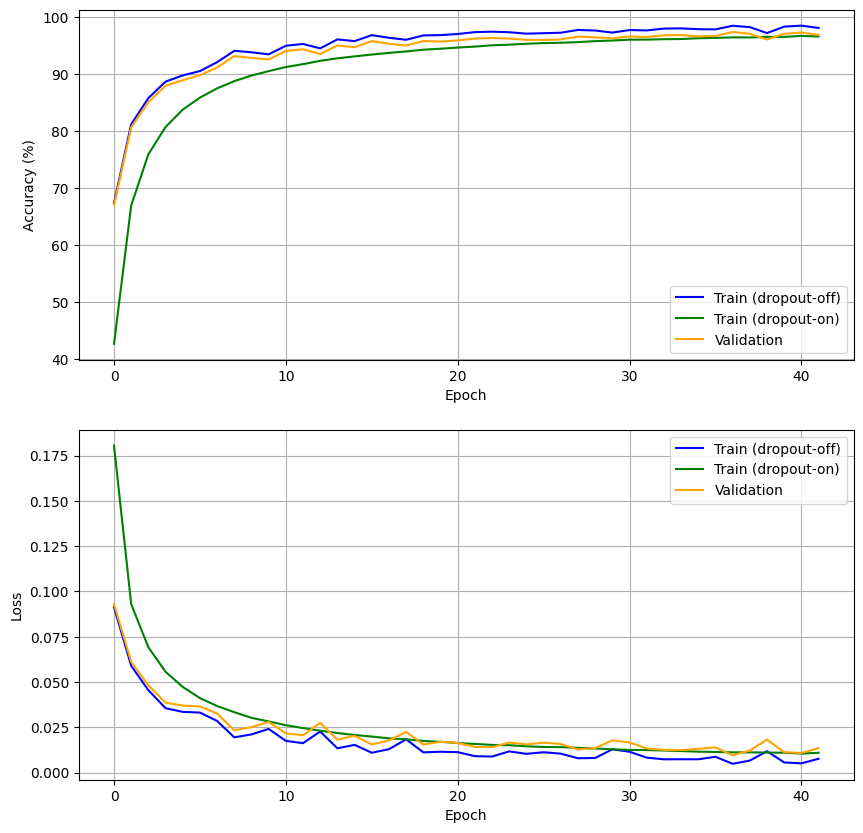

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(data['actual_accuracy'], color='blue')
ax1.plot(data['custom_accuracy'], color='green')
ax1.plot(data['val_custom_accuracy'], color='orange')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xlabel('Epoch')
ax1.legend(['Train (dropout-off)','Train (dropout-on)','Validation'], loc='lower right')
ax1.grid()

ax2.plot(data['actual_loss'], color='blue')
ax2.plot(data['loss'], color='green')
ax2.plot(data['val_loss'], color='orange')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train (dropout-off)','Train (dropout-on)','Validation'], loc='upper right')
ax2.grid()

plt.savefig('/content/gdrive/My Drive/Colab Notebooks/10_nodes_new/analysis/All/loss_accuracy.png', dpi=200, bbox_inches='tight')
plt.show()

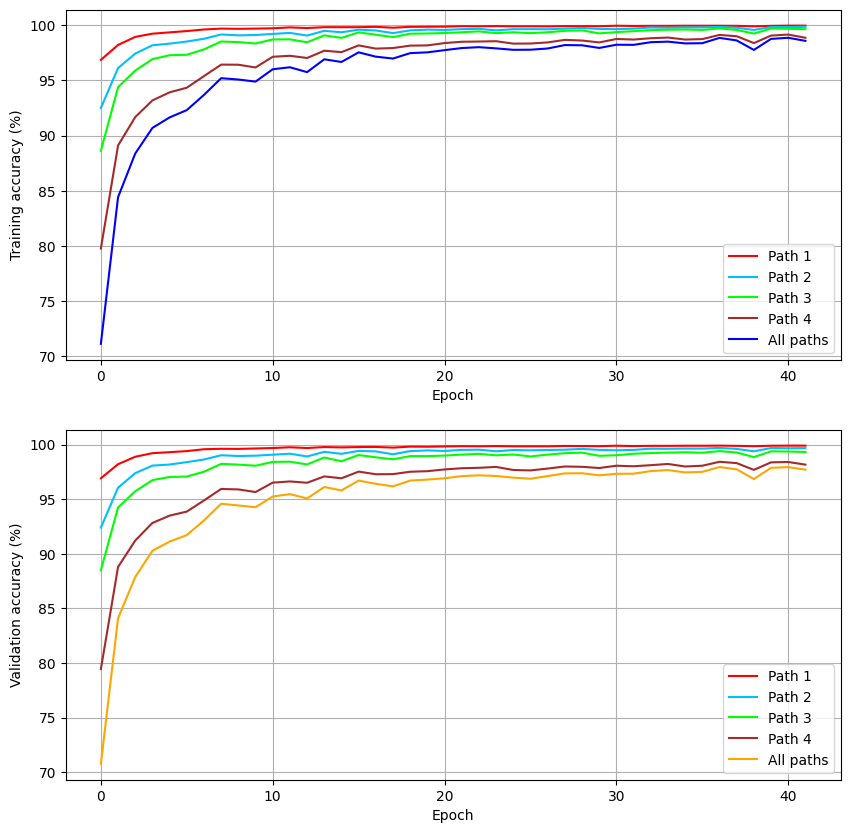

In [5]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(data["training_path_1"], color='red')
ax1.plot(data["training_path_2"], color='deepskyblue')
ax1.plot(data["training_path_3"], color='lime')
ax1.plot(data["training_path_4"], color='brown')
ax1.plot(data["training_all_paths"], color='blue')
ax1.set_ylabel('Training accuracy (%)')
ax1.set_xlabel('Epoch')
ax1.legend(['Path 1','Path 2','Path 3', 'Path 4', 'All paths'], loc='lower right')
ax1.grid()

ax2.plot(data["testing_path_1"], color='red')
ax2.plot(data["testing_path_2"], color='deepskyblue')
ax2.plot(data["testing_path_3"], color='lime')
ax2.plot(data["testing_path_4"], color='brown')
ax2.plot(data["testing_all_paths"], color='orange')
ax2.set_ylabel('Validation accuracy (%)')
ax2.set_xlabel('Epoch')
ax2.legend(['Path 1','Path 2','Path 3', 'Path 4', 'All paths'], loc='lower right')
ax2.grid()

plt.savefig('/content/gdrive/My Drive/Colab Notebooks/10_nodes_new/analysis/All/train_test_accuracy.png', dpi=200, bbox_inches='tight')
plt.show()